In [1]:
import os
import operator
from typing import TypedDict, List, Annotated, Literal
from dotenv import load_dotenv

# LangChain / LangGraph imports
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph

# Load API Key
load_dotenv()

# Initialize LLM
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [2]:
class QualityMetrics(BaseModel):
    """Quality scores and feedback for a written draft."""
    clarity: int = Field(description="Score from 1-5. 1=Unreadable, 5=Perfectly clear.")
    # UPDATED DESCRIPTION BELOW
    completeness: int = Field(description="Score from 1-5. CRITICAL: If ANY requested part (like code, examples, or specific points) is missing, score this 1 or 2.")
    accuracy: int = Field(description="Score from 1-5. 1=Factually wrong, 5=Correct.")
    critique: str = Field(description="Specific feedback. If scoring low, list exactly what is missing.")

    @property
    def is_passing(self) -> bool:
        return all(score >= 4 for score in [self.clarity, self.completeness, self.accuracy])

In [3]:
class ReflectionState(TypedDict):
    task: str
    draft: str
    metrics: QualityMetrics
    iteration: int
    score_history: List[QualityMetrics] # To track progress

In [4]:
MAX_ITERATIONS = 3

def generator_node(state: ReflectionState):
    task = state['task']
    draft = state.get('draft', "")
    metrics = state.get('metrics', None)
    iteration = state.get('iteration', 0)
    
    if iteration == 0:
        print(f"\n✍️  Generating initial draft...")
        msg = f"Write a response for this task:\n\n{task}"
    else:
        print(f"\n🔄  Refining draft (Iteration {iteration})...")
        print(f"    Feedback: {metrics.critique}")
        msg = f"""Improve the draft based on the critique.
        
        Task: {task}
        Current Draft: {draft}
        Critique: {metrics.critique}
        
        Ensure you address the feedback to improve the scores."""

    # Generate content
    response = llm.invoke([HumanMessage(content=msg)])
    
    return {
        "draft": response.content, 
        "iteration": iteration + 1
    }

def critic_node(state: ReflectionState):
    print(f"🔍  Critiquing draft...")
    draft = state['draft']
    task = state['task']
    
    structured_llm = llm.with_structured_output(QualityMetrics)
    
    # --- UPDATED PROMPT ---
    evaluation = structured_llm.invoke([
        SystemMessage(content="""You are a strict technical editor. 
        
        Your job is to compare the User Task against the Draft.
        
        CRITICAL RULES:
        1. If the task asks for code and the draft has NO code, Completeness MUST be 1.
        2. If the task asks for a specific format (e.g., list, python, json) and it's missing, penalize Completeness.
        3. Be harsh. Do not give 5s unless the draft is perfect.
        """),
        HumanMessage(content=f"USER TASK: {task}\n\nCURRENT DRAFT:\n{draft}")
    ])
    
    history = state.get('score_history', []) + [evaluation]
    
    print(f"    Scores -> Clarity: {evaluation.clarity}, Completeness: {evaluation.completeness}, Accuracy: {evaluation.accuracy}")
    
    return {
        "metrics": evaluation,
        "score_history": history
    }

In [5]:
def should_continue(state: ReflectionState) -> Literal["generator", "__end__"]:
    metrics = state['metrics']
    iteration = state['iteration']
    
    # Stop if scores are good enough
    if metrics.is_passing:
        print("✅  Scores met threshold (All >= 4). Stopping.")
        return "__end__"
    
    # Stop if max iterations reached
    if iteration > MAX_ITERATIONS:
        print(f"⚠️  Max iterations ({MAX_ITERATIONS}) reached. Stopping.")
        return "__end__"
        
    print(f"❌  Scores insufficient. Refining...")
    return "generator"

# Build the Graph
builder = StateGraph(ReflectionState)

builder.add_node("generator", generator_node)
builder.add_node("critic", critic_node)

builder.add_edge(START, "generator")
builder.add_edge("generator", "critic")
builder.add_conditional_edges("critic", should_continue)

app = builder.compile()

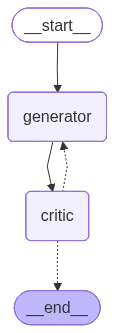

In [6]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except:
    print("Graph visualization requires mermaid support")

In [7]:
task = """
Explain the difference between python and javascript. 
Then, write a python and javascript code for a small command( DON'T FORGET THIS PART) 
The explanation should be simple enough for a beginner but accurate.
"""

# Run the graph
initial_state = {
    "task": task,
    "iteration": 0,
    "score_history": [] # Initialize empty history
}

result = app.invoke(initial_state)

print("\n" + "="*50)
print("FINAL OUTPUT")
print("="*50)
print(result['draft'])
print("\n" + "="*50)

# --- VISUALIZE SCORE IMPROVEMENT ---
print("\n📊 Score Improvement Tracking:\n")
history = result['score_history']

print(f"{'Iter':<5} | {'Clarity':<10} | {'Complete':<10} | {'Accuracy':<10} | {'Status'}")
print("-" * 55)

for i, m in enumerate(history):
    status = "✅ PASS" if m.is_passing else "❌ REFINE"
    print(f"{i+1:<5} | {m.clarity:<10} | {m.completeness:<10} | {m.accuracy:<10} | {status}")


✍️  Generating initial draft...
🔍  Critiquing draft...
    Scores -> Clarity: 4, Completeness: 2, Accuracy: 5
❌  Scores insufficient. Refining...

🔄  Refining draft (Iteration 1)...
    Feedback: The draft is missing a clear distinction in the execution environments and their implications for developers. Additionally, while the code examples are present, the task specifically requested a 'small command,' which could imply a more complex example or a specific functionality that is not fully explored here.
🔍  Critiquing draft...
    Scores -> Clarity: 5, Completeness: 5, Accuracy: 5
✅  Scores met threshold (All >= 4). Stopping.

FINAL OUTPUT
### Difference Between Python and JavaScript

Python and JavaScript are both widely-used programming languages, but they cater to different needs and have unique characteristics:

1. **Purpose**:
   - **Python**: Primarily used for backend development, data analysis, artificial intelligence, scientific computing, and automation. Its readability and 